# **Бинарная классификация при помощи ML и DL**

**Цель:** Классификация URL и IP на фишинговые/безопасные.

**Использованные алгоритмы:** Logistic Regression (sklearn), Random Forest (sklearn), SVM (sklearn), Neural Network (keras).

**Датасет:** Датасет состоит из 822010 записей — URL и классы (1 фишинговый/0 безопасный сайт).

**Источник данных:** https://www.kaggle.com/datasets/harisudhan411/phishing-and-legitimate-urls/data

**Загрузка библиотек:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix, 
                             ConfusionMatrixDisplay)

**Загрузка датасета:**

In [3]:
df = pd.read_csv('new_data_urls.csv')
df.sample(10)

,url,status
70539,https://www.icq-jcb.top/,0
69318,https://smcb-crad.com-men-indxe.7odrog.cn/,0
183589,https://pythonspot.com/en/python-network-socke...,1
43783,https://jp-myappleuser.servehttp.com/?sopote,0
48781,http://saitama.ageo.me/tmps/5/,0
755168,amvp.pt,0
314230,webmail.mhcable.com/secure/www.paypal.com/webs...,0
346615,commons.wikimedia.org/wiki/File:POL_Virtuti_Mi...,1
428102,sports.yahoo.com/mma/blog/cagewriter/post/Migu...,1
733243,http://utsikta.com/po9840/Hand/index.htm,0


**Размер датасета до предобработки:**

In [4]:
df.shape

(822010, 2)

**Наличие пропущенных значений:**

In [5]:
df.isna().sum()

url       0
status    0
dtype: int64

**Удаление дупликатов и размер датасета после удаления:**

In [6]:
df.drop_duplicates(subset=['url'], keep=False, inplace=True)
df.shape

(795230, 2)

**Измерение лейблов на противоположные (1 - фишинговые URL/ 0 - безопасные URL):**

In [7]:
df.rename(columns={'status': 'label'}, inplace=True)

In [8]:
df['label'] = df['label'].replace({0: 1, 1: 0})

**Сбалансированность выборки:**

In [9]:
df['label'].value_counts(normalize=True)

label
0    0.536987
1    0.463013
Name: proportion, dtype: float64

**Feature Engineering:**

In [ ]:
class URLFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    Класс для извлечения признаков из URL-ов для машинного обучения
    '''
    def __init__(self):
        '''
        1. Инициализация класса
        2. Задаем названия извлекаемых признаков
        '''
        self.feature_names_ = ["url_length",
                               "num_digits",
                               "num_special_chars",
                               "num_subdomains",
                               "has_ip",
                               "num_slashes"]

    def fit(self, X, y=None):
        '''
        Метод для обучения. Не делает ничего, возвращает сам себя
        '''
        return self
    
    def transform(self, X):
        '''
        Извлекаем признаки из X (колонка с URL-ами):

        1. Парсим URL (при помощи функции parse_url)
        2. Извлекаем признаки

        Возвращаем DataFrame с этими признаками
        '''
        urls = X if isinstance(X, (list, np.ndarray, pd.Series)) else X['url']
        features = []
        for url in urls:
            f = {}
            # Длина URL
            f['url_length'] = len(url)
            # Количество цифр
            f['num_digits'] = sum(c.isdigit() for c in url)
            # Количество специальных символов (@?=&%)
            f['num_special_chars'] = len(re.findall(r'[@?=&%]', url))
            # Количество поддоменов
            f['num_subdomains'] = url.count('.') - 1
            # Есть ли IP‑адрес
            f['has_ip'] = 1 if re.match(r'http[s]?://\d+\.\d+\.\d+\.\d+', url) else 0
            # Количество слэшей
            f['num_slashes'] = url.count('/')
            features.append(f)
            
        return pd.DataFrame(features)

    def get_feature_names_out(self, input_features=None):
        '''
        Возвращаем список названий признаков
        '''
        return np.array(self.feature_names_)

**Пайплайн предобработки данных с ручным отбором признаков, стандартизацией, TF-IDF:**

In [ ]:
# Извлечение и масштабирование признаков
url_features = Pipeline([('extract', URLFeatureExtractor()),
                         ('scale', StandardScaler())])

# Преобразование URL в TF-IDF признаки
tfidf = TfidfVectorizer(analyzer='char', 
                        ngram_range=(3,5), 
                        max_features=5000)

# Объединение в один преобразователь
preprocessor = ColumnTransformer(transformers=[('features', url_features, 'url'),
                                               ('tfidf', tfidf, 'url')])

**Разделение датасета на train и test:**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[['url']], 
                                                    df['label'], 
                                                    test_size=0.3, 
                                                    random_state=42)

**Определение размерности для нейронной сети:**

In [13]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Размерность после препроцессинга:", X_train_transformed.shape)

Размерность после препроцессинга: (556661, 5006)


**Архитектура нейронной сети:**

In [ ]:
input_dim = X_train_transformed.shape[1]

def create_nn_model(input_dim):
    '''
    Создаем и компилируем нейронную сеть для бинарной классификации
    '''
    model = tf.keras.Sequential([tf.keras.layers.Input(shape=(input_dim,)),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

nn_clf = KerasClassifier(model=create_nn_model,
                         model__input_dim=input_dim,
                         epochs=10,
                         batch_size=16,
                         verbose=0)

**Все модели:**

In [15]:
models = {"Logistic Regression": LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced'),
          "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
          "SVM": LinearSVC(class_weight='balanced', max_iter=5000),
          "Neural Network": nn_clf}

results = []
roc_curves = {}

**Обучение и оценка:**

In [16]:
for name, clf in models.items():
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('clf', clf)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # ROC-AUC
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)
        if y_proba.ndim > 1 and y_proba.shape[1] > 1:
            y_proba = y_proba[:, 1]
        else:
            y_proba = y_proba.ravel()
    else:
        try:
            y_proba = pipe.decision_function(X_test)
        except:
            y_proba = y_pred
    
    results.append({"Model": name,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "Precision": precision_score(y_test, y_pred, pos_label=1),
                    "Recall": recall_score(y_test, y_pred, pos_label=1),
                    "F1": f1_score(y_test, y_pred, pos_label=1),
                    "ROC-AUC": roc_auc_score(y_test, y_proba)})
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr)

**Таблица с результатами по каждой модели:**

In [17]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.953498   0.954962  0.943622  0.949258  0.989534
1        Random Forest  0.971258   0.974332  0.963018  0.968642  0.995758
2                  SVM  0.959207   0.960078  0.951051  0.955543  0.991707
3       Neural Network  0.977692   0.974612  0.977058  0.975833  0.997229


**Barplot по F1 каждой модели:**

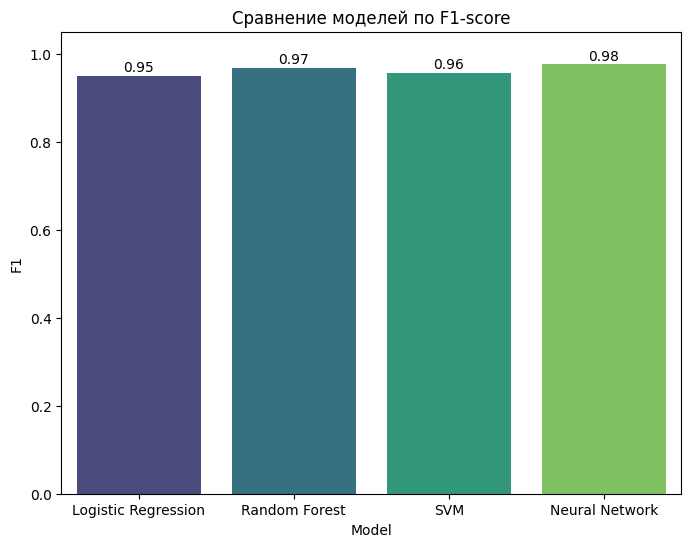

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="F1", 
            data=results_df, 
            hue='Model', 
            palette="viridis", 
            legend=False)

for i, v in enumerate(results_df["F1"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.title("Сравнение моделей по F1-score")
plt.ylim(0, 1.05)

plt.show()

**Confusion matrix для всех моделей:**

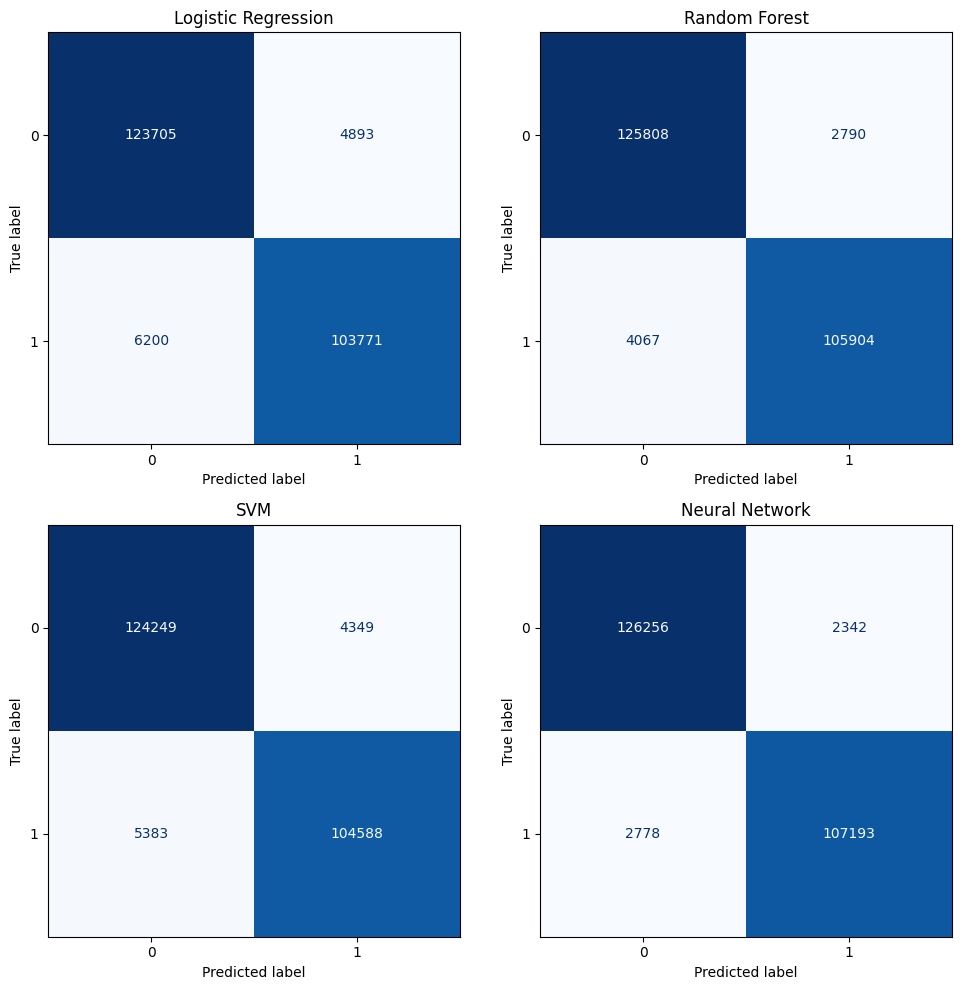

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, (name, clf) in zip(axes.flatten(), models.items()):
    # Пайплайн: препроцессор + модель
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

**ROC-кривые каждой модели:**

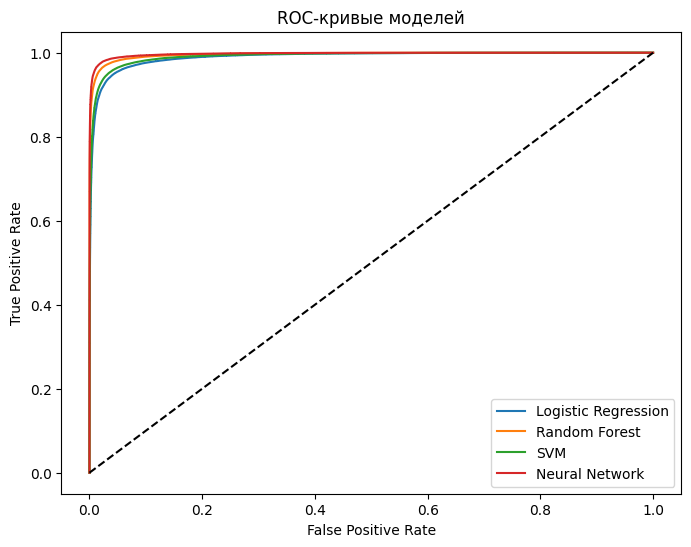

In [19]:
plt.figure(figsize=(8, 6))

for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые моделей")
plt.legend()

plt.show()

Для упрощения процесса интерпретации результатов берем модель **Random Forest**.